In [1]:
import pandas as pd
df = pd.read_csv('../assets/data/sanitized.txt')
print(df.shape)
df.head()

(3729, 13)


,player,completions,passatt,passyards,passtds,ints,sacks,sackyards,rushatt,rushyards,rushtds,fumbles,season
0,Eli Manning,23,42,256,1,1,2.0,18.0,2,-2,0,1,2013
1,Peyton Manning,32,51,400,4,0,1.0,3.0,0,0,0,0,2013
2,Cam Newton,13,22,181,1,1,4.0,40.0,4,6,0,0,2013
3,Carson Palmer,13,25,178,1,4,2.0,10.0,5,-3,0,0,2013
4,Philip Rivers,19,29,201,1,1,1.0,5.0,4,-3,0,1,2013


In [2]:
df1 = df.copy()

# engineer some features

# why these features in particular?
# I was guided by the following concerns:
# - represent several different aspects of QB play
# - reduce dimensions to simplify the model

df1['cmp%'] = df1['completions'] / df1['passatt']
df1['netatt'] = df1['passatt'] + df1['sacks']
df1['touches'] = df1['netatt'] + df1['rushatt']
df1['netyards'] = df1['passyards'] - df1['sackyards']
df1['ny/a'] = df1['netyards'] / df1['netatt']
df1['ypc'] = df1['rushyards'] / df1['rushatt']
df1['tds'] = df1['passtds'] + df1['rushtds']
df1['tos'] = df1['ints'] + df1['fumbles']
df1['td:touch'] = df1['tds'] / df1['touches']
df1['to:touch'] = df1['tos'] / df1['touches']
df1['totalyards'] = df1['netyards'] + df1['rushyards']
df1['rush-split'] = df1['rushyards'] / df1['totalyards']

# limit to our features
df1 = df1[['player', 'season', 'completions', 'passatt', 'passyards',
           'passtds', 'ints', 'sacks', 'sackyards', 'rushatt', 'rushyards',
           'rushtds', 'fumbles', 'touches', 'cmp%', 'ny/a', 'ypc',
           'rush-split', 'td:touch', 'to:touch']]

# fill NaN's introduced by our features
df1['cmp%'] = df1['cmp%'].fillna(0)
df1['ny/a'] = df1['ny/a'].fillna(0)
df1['ypc'] = df1['ypc'].fillna(0)
df1['rush-split'] = df1['rush-split'].fillna(0)

df1.isnull().sum()

player         0
season         0
completions    0
passatt        0
passyards      0
passtds        0
ints           0
sacks          0
sackyards      0
rushatt        0
rushyards      0
rushtds        0
fumbles        0
touches        0
cmp%           0
ny/a           0
ypc            0
rush-split     0
td:touch       0
to:touch       0
dtype: int64

In [3]:
df1.to_csv('../assets/data/engineered.txt', index=False)

In [4]:
# get league averages each year for each stat
stats = ['touches', 'cmp%', 'ny/a', 'ypc', 'rush-split', 'td:touch', 'to:touch']
data = []
for y in df1['season'].unique():
    df = df1[df1['season'] == y]
    row = dict(year=y)
    for s in stats:
        row[f'{s}-mean'] = df[s].mean()
        row[f'{s}-std'] = df[s].std()
    data.append(row)

df2 = pd.DataFrame(data)
df2.head()

,year,touches-mean,touches-std,cmp%-mean,cmp%-std,ny/a-mean,ny/a-std,ypc-mean,ypc-std,rush-split-mean,rush-split-std,td:touch-mean,td:touch-std,to:touch-mean,to:touch-std
0,2013,39.671141,10.716389,0.627488,0.106709,6.600505,2.044927,2.889356,4.089713,0.048849,0.095549,0.045448,0.033821,0.034888,0.032956
1,2009,35.856164,11.076113,0.618318,0.149707,6.607705,2.790235,2.408484,3.726143,0.059043,0.168791,0.047596,0.043012,0.034415,0.032109
2,2019,40.072165,11.373624,0.652522,0.117114,6.649210,2.082392,2.610007,3.782029,0.037123,0.106522,0.040263,0.035131,0.029947,0.033317
3,2007,35.005000,11.575619,0.632580,0.144469,6.628798,2.474819,2.285500,3.795700,0.031373,0.087641,0.052123,0.048801,0.027099,0.042884
4,2017,38.724444,9.647565,0.633493,0.105261,6.394702,1.904185,2.918096,5.817306,0.050367,0.102361,0.042999,0.029123,0.030621,0.035412


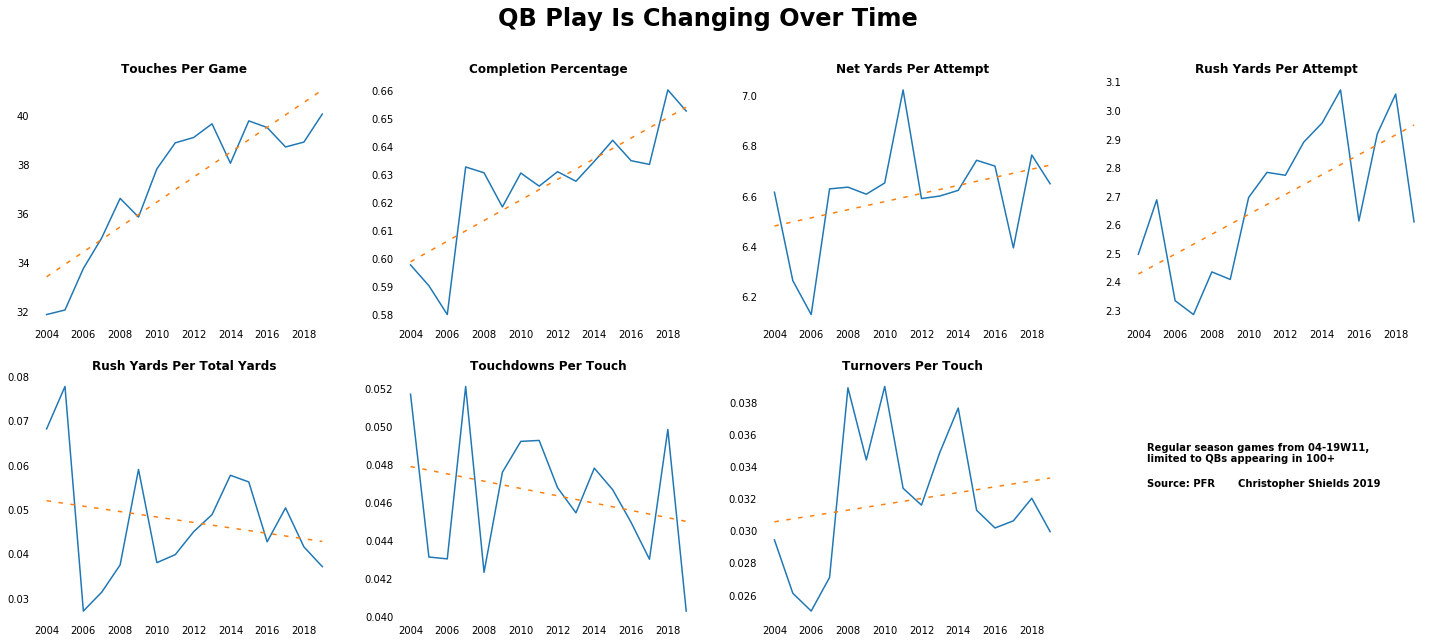

In [7]:
# why we need to adjust for year:
# there is a general trend of QBs getting
# better, even in this short window of time

import matplotlib.pyplot as plt
import numpy as np
df2 = df2.sort_values('year')

fig, axs = plt.subplots(2,4, figsize=(25,10))
x = df2['year']

def hide_spines(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)

def plot_data(ax, y, tit):
    bf = np.poly1d(np.polyfit(x, y, 1))
    ax.plot(x, y)
    ax.plot(x, bf(x), dashes=(3,5))
    ax.tick_params(axis='both', length=0)
    hide_spines(ax)
    ax.set_title(tit, fontweight='bold')

# graph the data
plot_data(axs[0,0], df2['touches-mean'], 'Touches Per Game')
plot_data(axs[0,1], df2['cmp%-mean'], 'Completion Percentage')
plot_data(axs[0,2], df2['ny/a-mean'], 'Net Yards Per Attempt')
plot_data(axs[0,3], df2['ypc-mean'], 'Rush Yards Per Attempt')
plot_data(axs[1,0], df2['rush-split-mean'], 'Rush Yards Per Total Yards')
plot_data(axs[1,1], df2['td:touch-mean'], 'Touchdowns Per Touch')
plot_data(axs[1,2], df2['to:touch-mean'], 'Turnovers Per Touch')

# cannibalize the last section
axs[1,3].tick_params(axis='both', length=0, labelcolor='white')
hide_spines(axs[1,3])
axs[1,3].text(0.075, 0.65,
              'Regular season games from 04-19W11,\nlimited to QBs appearing in 100+',
              fontweight='bold')
axs[1,3].text(0.075, 0.55,
              'Source: PFR',
              fontweight='bold')
axs[1,3].text(0.375, 0.55,
              'Christopher Shields 2019',
              fontweight='bold')

# plot meta
fig.suptitle('QB Play Is Changing Over Time', fontweight='bold', fontsize=24)
plt.savefig('../assets/overtime.png')
plt.show()

In [8]:
df2.to_csv('../assets/data/years.txt', index=False)